### **Problem Statement**

Credit risk is a critical challenge for financial institutions, as it directly impacts profitability and capital adequacy. Accurately identifying high-risk loans and estimating potential losses are essential for effective risk management. This project aims to develop a robust credit risk segmentation model using machine learning techniques to classify loans into risk levels, estimate expected losses, and calculate risk-adjusted returns. The insights derived from this analysis can guide financial institutions in pricing loans, setting capital reserves, and mitigating default risks.

### Methodology

#### **1. Data Description and Preprocessing**
The dataset contains loan-related information, including variables such as loan amount, interest rate, and borrower characteristics. Preprocessing steps included:
- Imputing missing values using appropriate statistical methods.
- Encoding categorical features using one-hot encoding for logistic regression and label encoding for random forests and XGBoost.
- Scaling numerical variables to ensure consistency across models.

#### **2. Exploratory Data Analysis (EDA)**
- Analyzed the distribution of key variables such as loan amount and default status.
- Conducted correlation analysis to identify relationships between features.
- Explored default rates across different borrower segments using visualizations.

#### **3. Credit Risk Model Development**

##### Logistic Regression
- Logistic Regression was used as a baseline model to estimate the **Probability of Default (PD)**.
- This model provided interpretable coefficients to understand the impact of features on default probability.

##### Random Forests
- A Random Forest classifier was trained to predict PD, leveraging its ability to capture non-linear relationships and interactions between features.
- RandomizedSearchCV was used to tune hyperparameters, such as `n_estimators`, `max_depth`, and `min_samples_split`.

##### XGBoost
- The XGBoost algorithm was applied to further improve predictive accuracy.
- Key hyperparameters such as `learning_rate`, `max_depth`, and `n_estimators` were optimized using GridearchCV.

##### Model Evaluation
- Each model was evaluated using **ROC-AUC** to measure its ability to distinguish between default and non-default cases.
- Cross-validation ensured robust performance estimates for all models.

#### **4. Calculation of Expected Loss (EL)**
For each loan, the **Expected Loss (EL)** was calculated using the formula:
$ \text{Expected Loss} = \text{PD} \times \text{LGD} \times \text{EAD} $

- **PD** was obtained from the model predictions.
- **LGD** was set as a randomized constant due to the unavailability of recovery rate data.
- **EAD** was derived directly from the loan amount.

#### **5. Clustering for Risk Segmentation**
- K-Means clustering was used to segment loans into risk categories (High Risk, Medium Risk, Low Risk) based on PD, EL, and RAROC.
- The silhouette score was calculated to evaluate clustering quality.

#### **6. Risk-Adjusted Return on Capital (RAROC)**
The RAROC for each loan was computed as:
\[
\text{RAROC} = \frac{\text{Interest Income}}{\text{Expected Loss}}
\]
This metric provided insights into the profitability of loans relative to their risk.

#### **7. Evaluation Metrics**
- **ROC-AUC** scores were compared across Logistic Regression, Random Forests, and XGBoost to determine the best-performing model.
- Cluster-level analysis was conducted to validate the risk segmentation and its business implications.

#### **8. Assumptions**
- The LGD was set as a randomized constant due to the absence of recovery rate data.
- Loan defaults were assumed to be independent, with no correlated risks.


### **Assumptions and Limitations**

#### **LGD Assumption**
Due to the unavailability of recovery rate data in the dataset, the Loss Given Default (LGD) was approximated using a randomized constant. This approach assumes a static LGD across all loans, which may not fully capture real-world variability. Future work could incorporate actual recovery rate data or estimate LGD using external benchmarks or industry standards.

#### **Limitations**
- The LGD used in this analysis was generated as a randomized constant due to the absence of recovery rate data. This simplification may impact the precision of expected loss calculations and the derived RAROC values.
- Incorporating dynamic or historical LGD data would enhance the model's accuracy and provide more realistic insights into credit risk levels.

#### **Recommendations**
- To improve the accuracy of credit risk segmentation, obtaining detailed recovery rate data would allow for a more realistic calculation of LGD.
- Alternatively, LGD estimates could be sourced from historical data or industry reports for more robust modeling.


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [56]:
#Load the data
path = r"C:\Users\pc\Downloads\cr_loan2.csv"

credit_df = pd.read_csv(path)

display(credit_df.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [57]:
#check the dtypes of the data
print(credit_df.dtypes)

#check if null values exist within the dataframe
display(credit_df.isnull().sum())

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

By looking at the results, we can clearly see that the variables "person_emp_length" & "loan_int_rate" contains 895 & 3116 "NaN" values respectively.

In [58]:
#lets compare the frequency of variables with the help of cross tabulation. When it comes to business problems in banking, the main
#variable focus would be the loan status of each person to find ways to reduce loss for the bank

crosstab_1 = pd.crosstab(credit_df["loan_status"], credit_df["person_home_ownership"],
                         values = credit_df["person_income"], aggfunc= "mean").round(3)

display(crosstab_1)

crosstab_2 = pd.crosstab(credit_df["loan_status"], credit_df["person_home_ownership"],
                         values = credit_df["loan_int_rate"], aggfunc = "mean").round(3)

display(crosstab_2)

crosstab_3 = pd.crosstab(credit_df["loan_status"], credit_df["loan_intent"],
                         values = credit_df["person_income"], aggfunc= "mean").round(3)

display(crosstab_3)

crosstab_4 = pd.crosstab(credit_df["person_home_ownership"], [credit_df["loan_status"], credit_df["loan_grade"]])

display(crosstab_4)




person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,82849.74,88585.608,60394.306,60318.601
1,69146.26,49035.152,26126.275,43464.450


person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_status,,,,
0,10.060,11.414,10.755,10.753
1,13.432,13.562,12.237,12.966


loan_intent,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE
loan_status,,,,,,
0,71588.914,67745.395,82085.335,65422.364,73055.192,70263.073
1,53686.086,46776.365,49384.174,50497.152,46953.378,44088.697


loan_status               0                                 1             \
loan_grade                A     B     C    D    E   F  G    A     B    C   
person_home_ownership                                                      
MORTGAGE               5219  3729  1934  658  178  36  0  239   324  321   
OTHER                    23    29    11    9    2   0  0    3     5    6   
OWN                     860   770   464  264   26   7  0   66    34   31   
RENT                   3602  4222  2710  554  137  28  1  765  1338  981   

loan_status                               
loan_grade                D    E   F   G  
person_home_ownership                     
MORTGAGE                553  161  61  31  
OTHER                    11    6   2   0  
OWN                      18   31   8   5  
RENT                   1559  423  99  27

<h4><b>Crosstab_1:</b></h4>

* According to the mean of personal income for the groups who have defaulted & not defaulted when it came to personal home ownership, the group who have defaulted had lower income compared to individuals who have not defaulted across every personal home ownership category.

<h4><b>Crosstab_2:</b></h4>

* According to the mean of loan interest rates for the groups who have defaulted & not defaulted when it came to personal home ownership,
the group who have defaulted had higher interest rate compared to the group who have not defaulted across every perosonal home ownership category.

<h4><b>Crosstab_3:</b></h4>

* According to the mean of personal income for the groups who have defaulted & not defaulted when it came to their loan intensions, the group who have defaulted seem to have trouble paying off their dues due to having lower income than the other group who had no trouble paying off their dues.

<h4><b>Crosstab_4:</b></h4>

* According to frequency of both default and non-default groups when it comes to grading their loans based on home ownership status, clients who lived off through mortages & rent and had defaulted on their loans had the worst loan grade which is G (highest risk).

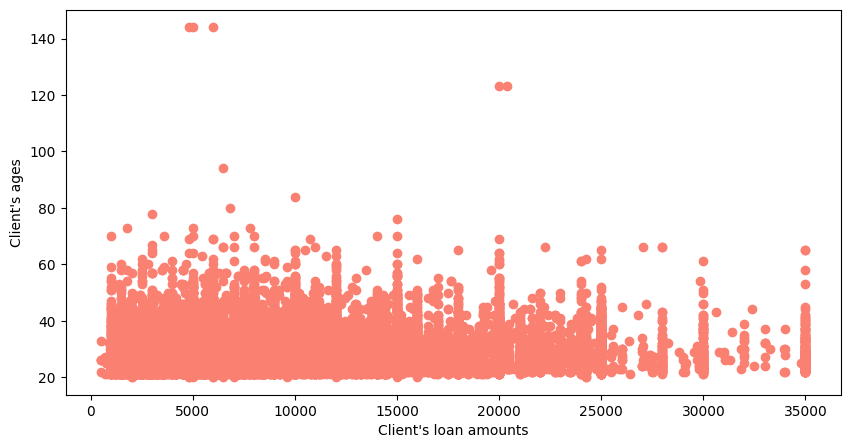

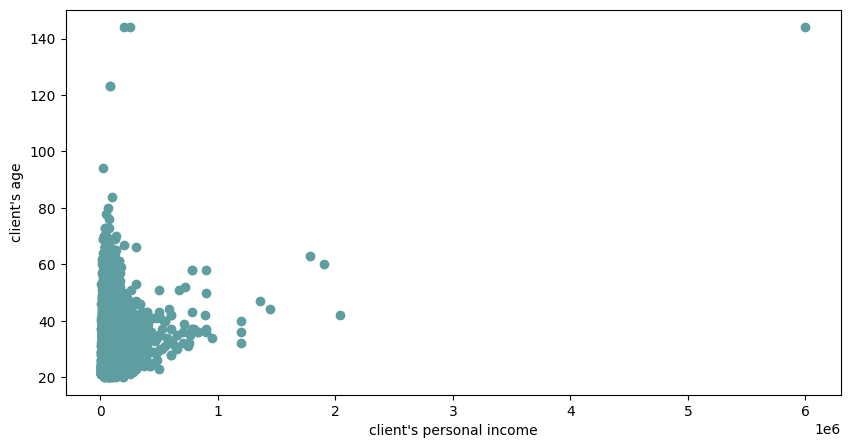

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


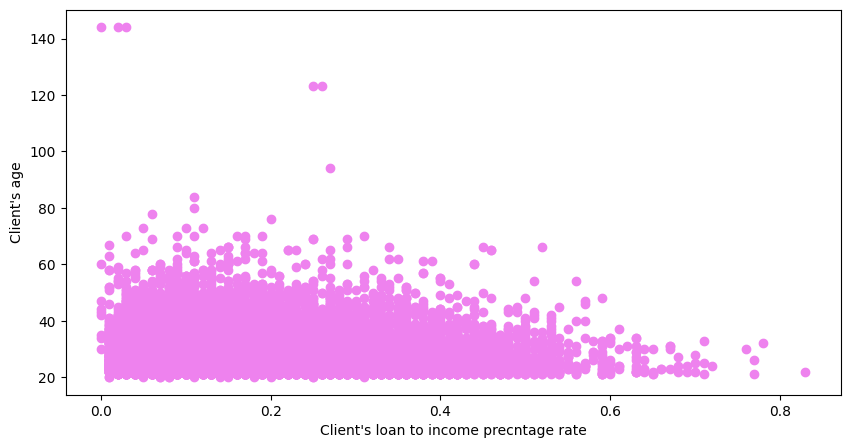

In [59]:
plt.figure(figsize = (10,5))
plt.scatter(y = credit_df["person_age"], x = credit_df["loan_amnt"], color = "salmon")
plt.xlabel("Client's loan amounts")
plt.ylabel("Client's ages")
plt.show()

plt.figure(figsize = (10, 5))
plt.scatter(y = credit_df["person_age"], x = credit_df["person_income"], color = "cadetblue")
plt.xlabel("client's personal income")
plt.ylabel("client's age")
plt.show()

display(credit_df.head())

plt.figure(figsize = (10,5))
plt.scatter(x = credit_df["loan_percent_income"], y = credit_df["person_age"], color = "violet")
plt.xlabel("Client's loan to income precntage rate")
plt.ylabel("Client's age")
plt.show()

<h3><b>Data preprocessing</b></h4>

In [60]:
for column in credit_df.columns:
    if credit_df[column].dtype not in ["int64", "float64"]:
        print(f"{column} levels: {len(credit_df[column].unique())}")

person_home_ownership levels: 4
loan_intent levels: 6
loan_grade levels: 7
cb_person_default_on_file levels: 2


In [61]:
#now we need to gather the categorical (cat), ordinal categorical (car), numeric categorical, and numeric columns

#we need to set a threshold of 10 for nominal categorical variables because those type of variables are not ordered and harder to interpret 

#a 20 threshold for ordinal categorical varaibles because they are ordered and easier to interpret

def get_column_category(dataframe, cat_thresh = 10, car_thresh = 20):
    categorical_columns = [column for column in dataframe.columns if dataframe[column].dtypes == "O"]
    categorical_col_but_car = [column for column in dataframe.columns
                               if dataframe[column].nunique() > car_thresh and dataframe[column].dtypes == "O"]
    numerical_but_categorical = [column for column in dataframe.columns
                                 if dataframe[column].nunique() < cat_thresh and dataframe[column].dtypes != "O"]
    
    #add the categorical variables from the numerical cat list if column does not exist in the ordinal list
    categorical_columns += numerical_but_categorical
    categorical_columns = [column for column in categorical_columns if column not in categorical_col_but_car]

    #add the numeric columns from the dataframe to a numeric column list 
    numeric_columns = [column for column in dataframe.columns if dataframe[column].dtypes != "O"]
    #add the numeric columns to the numeric column list if column does not exist in the nominal numerical list
    numeric_columns = [column for column in numeric_columns if column not in numerical_but_categorical]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Number of Variables: {len(dataframe.columns)}")
    print(f"Nominal Categorial Variables: {len(categorical_columns)}")
    print(f"Ordinal Categorical Variables: {len(categorical_col_but_car)}")
    print(f"Nominal Numeric Cat Variables: {len(numerical_but_categorical)}")
    print(f"Numeric Variables: {len(numeric_columns)}")

    return categorical_columns, categorical_col_but_car, numerical_but_categorical, numeric_columns


nominal_cat, ordinal_cat, nominal_num, num_cols = get_column_category(credit_df)
    

Observations: 32581
Number of Variables: 12
Nominal Categorial Variables: 5
Ordinal Categorical Variables: 0
Nominal Numeric Cat Variables: 1
Numeric Variables: 7


In [62]:
def outlier_threshold(dataframe, target_col, q1 = 0.01, q3 = 0.99):
    #Create the upper and lower quartiles
    upper_quartile = dataframe[target_col].quantile(q3)
    lower_quartile = dataframe[target_col].quantile(q1)

    #create the interquartile range
    interquartile_range = upper_quartile - lower_quartile

    #create the upper and lower bounds

    upper_bound = upper_quartile + 1.5 * interquartile_range
    lower_bound = lower_quartile - 1.5 * interquartile_range

    return upper_bound, lower_bound


def check_outliers(dataframe, target_column):
    #set the threshold for the outliers by using the function we created above
    upper_bound, lower_bound = outlier_threshold(dataframe, target_column)
    #set the conditional statements for the thresholds
    if dataframe[(dataframe[target_column] > upper_bound) | (dataframe[target_column] < lower_bound)].any(axis =None):
        return True
    return False

In [63]:
for column in num_cols:
    print(f"{column}: {check_outliers(credit_df, column)}")

print("-"* 80)

outlier_threshold(credit_df, num_cols)

person_age: True
person_income: True
person_emp_length: True
loan_amnt: False
loan_int_rate: False
loan_percent_income: False
cb_person_cred_hist_length: False
--------------------------------------------------------------------------------


(person_age                        93.50
 person_income                 541400.00
 person_emp_length                 45.00
 loan_amnt                      73000.00
 loan_int_rate                     38.42
 loan_percent_income                1.22
 cb_person_cred_hist_length        39.50
 dtype: float64,
 person_age                       -22.50
 person_income                -301800.00
 person_emp_length                -27.00
 loan_amnt                     -42200.00
 loan_int_rate                    -14.38
 loan_percent_income               -0.70
 cb_person_cred_hist_length       -20.50
 dtype: float64)

In [64]:
#check the age groups that are older than the maximum value

older93 = credit_df[credit_df["person_age"] > 93]

print(f"Number of clients older than the maximum threshold: {len(older93)}")

Number of clients older than the maximum threshold: 6


In [65]:
#define a function replaces the outliers with the threshold

def replace_outlier(dataframe, column_name):
    upper_bounds, lower_bounds = outlier_threshold(dataframe, column_name)
    dataframe.loc[(dataframe[column_name] > upper_bounds), column_name] = upper_bounds
    dataframe.loc[(dataframe[column_name] < lower_bounds), column_name] = lower_bounds


#use the above function to replace the outliers of credit_df with the threshold
for column in num_cols:
    replace_outlier(credit_df, column)

#ensure that no outliers exist within the dataframe again
for column in num_cols:
    print(f"{column}: {check_outliers(credit_df, column)}")



person_age: False
person_income: False
person_emp_length: False
loan_amnt: False
loan_int_rate: False
loan_percent_income: False
cb_person_cred_hist_length: False


C:\Users\pc\AppData\Local\Temp\ipykernel_4584\3714752168.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '93.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[column_name] > upper_bounds), column_name] = upper_bounds
C:\Users\pc\AppData\Local\Temp\ipykernel_4584\3714752168.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '541400.0000000019' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[column_name] > upper_bounds), column_name] = upper_bounds
C:\Users\pc\AppData\Local\Temp\ipykernel_4584\3714752168.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '39.5' has dtype incompatible with int64, please explici

In [66]:
#now lets deal with our missing values

credit_df.isnull().sum()

#replace the null values with the median

credit_df["person_emp_length"] = credit_df["person_emp_length"].fillna(credit_df["person_emp_length"].median())
credit_df["loan_int_rate"] = credit_df["loan_int_rate"].fillna(credit_df["loan_int_rate"].median())


#ensure the null values have been removed successfully
credit_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

<h3><b>Building Our logisitic regression model:</b></h4>

<p>Before fitting our dataset into the logistic regression model, we have to first one hot encode our categorical variables in order to have our model read it successfully without having the trouble of running into a <b>"TypeError"</b>.</P>

In [67]:
#Define the rare analyzer function to count the number of levels that exist within the column
def rare_analyzer(dataframe, target_var, nominal_cat):
    for column in nominal_cat:
        print(column, ":", len(dataframe[column].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[column].value_counts(),
                            "RATIO": dataframe[column].value_counts() / len(dataframe),
                            "TARGET_NAME": dataframe.groupby(column)[target_var].mean()}), end = "\n\n\n\"")
        
rare_analyzer(credit_df, "loan_status", nominal_cat=nominal_cat)

#define the one hot encoder function to set each nominal variable to binary levels

def one_hot_encoder(dataframe, nominal_cat, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns = nominal_cat, drop_first=drop_first)
    return dataframe

credit_new = credit_df.copy()

ohe_columns = [column for column in credit_new.columns if 10 >= credit_new[column].nunique() >= 2 and column != "loan_status"]

#encode the nominal variables


credit_new = one_hot_encoder(credit_new, ohe_columns, drop_first=True)

display(credit_new)

person_home_ownership : 4
                       COUNT     RATIO  TARGET_NAME
person_home_ownership                              
MORTGAGE               13444  0.412633     0.125707
OTHER                    107  0.003284     0.308411
OWN                     2584  0.079310     0.074690
RENT                   16446  0.504773     0.315700


"loan_intent : 6
                   COUNT     RATIO  TARGET_NAME
loan_intent                                    
DEBTCONSOLIDATION   5212  0.159971     0.285879
EDUCATION           6453  0.198060     0.172168
HOMEIMPROVEMENT     3605  0.110647     0.261026
MEDICAL             6071  0.186336     0.267007
PERSONAL            5521  0.169455     0.198877
VENTURE             5719  0.175532     0.148103


"loan_grade : 7
            COUNT     RATIO  TARGET_NAME
loan_grade                              
A           10777  0.330776     0.099564
B           10451  0.320770     0.162760
C            6458  0.198214     0.207340
D            3626  0.111292     0.59

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22.0,59000.0,45.0,35000,16.02,1,0.59,3.0,False,False,...,False,True,False,False,False,True,False,False,False,True
1,21.0,9600.0,5.0,1000,11.14,0,0.10,2.0,False,True,...,False,False,False,True,False,False,False,False,False,False
2,25.0,9600.0,1.0,5500,12.87,1,0.57,3.0,False,False,...,True,False,False,False,True,False,False,False,False,False
3,23.0,65500.0,4.0,35000,15.23,1,0.53,2.0,False,False,...,True,False,False,False,True,False,False,False,False,False
4,24.0,54400.0,8.0,35000,14.27,1,0.55,4.0,False,False,...,True,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57.0,53000.0,1.0,5800,13.16,0,0.11,30.0,False,False,...,False,True,False,False,True,False,False,False,False,False
32577,54.0,120000.0,4.0,17625,7.49,0,0.15,19.0,False,False,...,False,True,False,False,False,False,False,False,False,False
32578,65.0,76000.0,3.0,35000,10.99,1,0.46,28.0,False,False,...,False,False,False,True,False,False,False,False,False,False
32579,56.0,150000.0,5.0,15000,11.48,0,0.10,26.0,False,False,...,False,True,False,True,False,False,False,False,False,False


In [84]:
from sklearn.linear_model import LogisticRegression



X_lr = credit_new.drop(["loan_status"], axis = 1)

Y_lr = credit_new["loan_status"]

logistic = LogisticRegression(random_state= 42, max_iter=1000).fit(X_lr, Y_lr)

display(logistic.coef_)

logistic.intercept_

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[-6.79726614e-02, -3.63079282e-05, -2.61035489e-02,
         1.06362062e-04,  1.79629458e-01,  4.15893604e-01,
         8.14779175e-02,  3.60985191e-02, -9.99032854e-01,
         6.81901211e-01, -7.26262234e-01,  4.57239114e-01,
        -1.98548678e-01, -4.89775003e-01, -9.09716563e-01,
        -4.95367077e-01, -9.62202777e-01,  1.10642052e+00,
         7.26982542e-01,  2.29196797e-01,  1.24564503e-01,
         1.95264809e-01]])

array([-0.81782445])

In [85]:
y_pred_lr = logistic.predict(X_lr)

y_pred_lr[:5]

array([1, 0, 0, 1, 1])

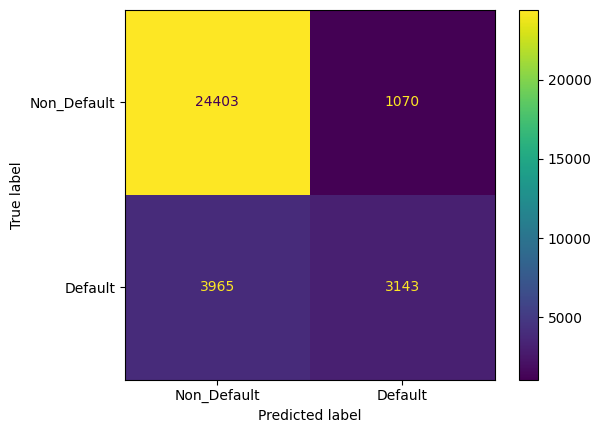

In [86]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

confusion_m = confusion_matrix(Y_lr, y_pred_lr) 

ConfusionMatrixDisplay(confusion_matrix= confusion_m, display_labels = ["Non_Default", "Default"]).plot()


In [87]:
#split the model

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, Y_lr, test_size= 0.2, random_state= 42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#apply standardization to continuous variables

continuous_cols = [column for column in credit_new.columns if credit_new[column].dtypes in ["int64", "float64"] and column != "loan_status"]

X_train_lr[continuous_cols] = scaler.fit_transform(X_train_lr[continuous_cols])
X_test_lr[continuous_cols]  = scaler.transform(X_test_lr[continuous_cols])

logistic_model = LogisticRegression(random_state = 42, max_iter = 1000).fit(X_train_lr, y_train_lr)

y_pred_lr = logistic_model.predict(X_test_lr)

y_proba_lr = logistic_model.predict_proba(X_test_lr)[:, 1]

display(y_proba_lr)

from sklearn.metrics import classification_report

logistic_report = classification_report(y_test_lr, y_pred_lr)

print(logistic_report)




array([0.22981665, 0.19389349, 0.32441808, ..., 0.02482832, 0.03896009,
       0.04325826])

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      5072
           1       0.76      0.55      0.64      1445

    accuracy                           0.86      6517
   macro avg       0.82      0.75      0.78      6517
weighted avg       0.85      0.86      0.85      6517



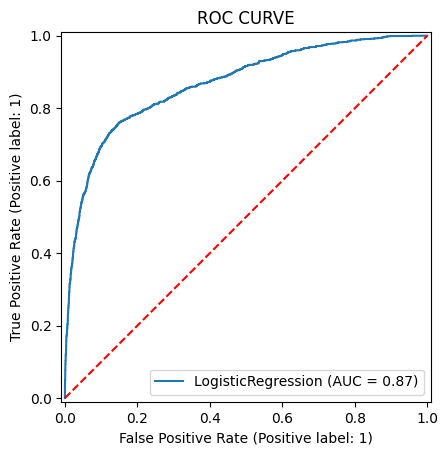

np.float64(0.8682397694650323)

In [88]:
#ROC and AUC curve

#ROC curve
from sklearn.metrics import roc_auc_score, RocCurveDisplay
RocCurveDisplay.from_estimator(logistic_model, X_test_lr, y_test_lr)
plt.title("ROC CURVE")
plt.plot([0, 1], [0, 1], "r--")
plt.show()

roc_auc_score(y_test_lr, y_proba_lr)


In [89]:
#Before proceeding with cross validation, ensure that no outliers exist within the dataframe after training it
for column in num_cols:
    print(f"{column}: {check_outliers(credit_new, column)}")


for column in num_cols:
    replace_outlier(credit_new, column)


print("-"* 1000)

for column in num_cols:
    print(f"{column}: {check_outliers(credit_new, column)}")

person_age: False
person_income: False
person_emp_length: False
loan_amnt: False
loan_int_rate: False
loan_percent_income: False
cb_person_cred_hist_length: False
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [90]:
#ensure missing values do not exist within the dataframe

credit_new.isnull().sum()

#ensure the nominal categorical variables are also encoded

credit_new.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,22.0,59000.0,42.5,35000,16.02,1,0.59,3.0,False,False,...,False,True,False,False,False,True,False,False,False,True
1,21.0,9600.0,5.0,1000,11.14,0,0.10,2.0,False,True,...,False,False,False,True,False,False,False,False,False,False
2,25.0,9600.0,1.0,5500,12.87,1,0.57,3.0,False,False,...,True,False,False,False,True,False,False,False,False,False
3,23.0,65500.0,4.0,35000,15.23,1,0.53,2.0,False,False,...,True,False,False,False,True,False,False,False,False,False
4,24.0,54400.0,8.0,35000,14.27,1,0.55,4.0,False,False,...,True,False,False,False,True,False,False,False,False,True


In [91]:
#Let's cross validate our logistic regression model
from sklearn.linear_model import LogisticRegressionCV

log_estimator = LogisticRegressionCV(Cs = 10,
                                      cv = 10,
                                      scoring = "roc_auc",
                                      class_weight ="balanced",
                                      solver = "lbfgs",
                                      max_iter = 1000,
                                      random_state = 42)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
Xtrain_lr_resampled, ytrain_lr_resampled = smote.fit_resample(X_train_lr, y_train_lr)

In [92]:
log_estimator_cv = log_estimator.fit(Xtrain_lr_resampled, ytrain_lr_resampled)

y_pred_lr_cv = log_estimator_cv.predict(X_test_lr)
y_proba_lr_cv = log_estimator_cv.predict_proba(X_test_lr)[:, 1]

In [93]:
print(f"Accuracy Score: {round(accuracy_score(y_test_lr, y_pred_lr_cv),2)}")
print(f"ROC_AUC Score: {round(roc_auc_score(y_test_lr, y_pred_lr_cv),2)}")
print(f"f1 Score: {round(f1_score(y_test_lr, y_pred_lr_cv),2)}")
print(f"Optimal C: {log_estimator_cv.C_}")

Accuracy Score: 0.81
ROC_AUC Score: 0.8
f1 Score: 0.64
Optimal C: [2.7825594]


<h3><b>Random Forests:</b></h3>

<p>Since we will be using random forests, which is an ensemble method. we wont be using the one hot encoding method to transform our categorical variables into binary levels. Random Forests already know how to deal with those kind variables well but it requires a specific encoding method called the label encoding, which is only designed for the random forests classifier.</p>

In [95]:
from sklearn.ensemble import RandomForestClassifier

#ensure that the dataframe contains no outliers and no missing values

credit_df.isnull().sum()

for column in num_cols:
    print(f"{column}: {check_outliers(credit_df, column)}")

for column in num_cols:
    replace_outlier(credit_df, column)

display(f"Post Outlier replacements:")

for column in num_cols:
    print(f"{column}: {check_outliers(credit_df, column)}")

person_age: False
person_income: False
person_emp_length: True
loan_amnt: False
loan_int_rate: False
loan_percent_income: False
cb_person_cred_hist_length: False


'Post Outlier replacements:'

person_age: False
person_income: False
person_emp_length: False
loan_amnt: False
loan_int_rate: False
loan_percent_income: False
cb_person_cred_hist_length: False


In [96]:
from sklearn.preprocessing import LabelEncoder
#label encode the numeric variables
label_encoder = LabelEncoder()

le_cols = [column for column in credit_df.columns if 10 >= credit_df[column].nunique() >= 2 and column != "loan_status"]

for column in le_cols:
    credit_df[column] = label_encoder.fit_transform(credit_df[column])

#create the new constants
X = credit_df.drop(["loan_status"], axis = 1)
Y = credit_df["loan_status"]

#split the data 
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, Y, test_size = 0.2, random_state = 42)

#adjust the random forest classifier class and assign it to an object
random_forest = RandomForestClassifier(n_estimators= 1000, oob_score= True, random_state = 42, criterion = "gini", class_weight= "balanced")

#fit the object
random_forest = random_forest.fit(X_train_rf, y_train_rf)

#make predicitions
y_pred_rf = random_forest.predict(X_test_rf)


array([0, 0, 0, 1, 1])

Out of Bag Score: 0.93


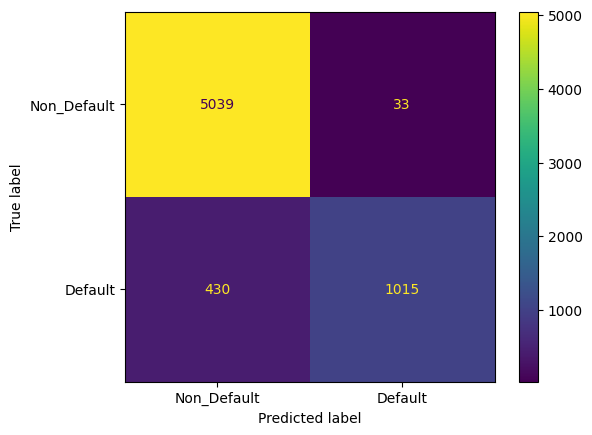

In [97]:
display(y_pred_rf[:5])

#plot the confusion matrix
confusion_m = confusion_matrix(y_test_rf, y_pred_rf)

ConfusionMatrixDisplay(confusion_matrix = confusion_m, display_labels = ["Non_Default", "Default"]).plot()

print(f"Out of Bag Score: {round(random_forest.oob_score_, 2)}")

In [98]:
#display the classification report of random forests

random_forest_report = classification_report(y_test_rf, y_pred_rf)

print(random_forest_report)

y_prob_rf = random_forest.predict_proba(X_test_rf)[:,1]

display(y_prob_rf)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5072
           1       0.97      0.70      0.81      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.85      0.89      6517
weighted avg       0.93      0.93      0.92      6517



array([0.026, 0.189, 0.282, ..., 0.061, 0.036, 0.059])

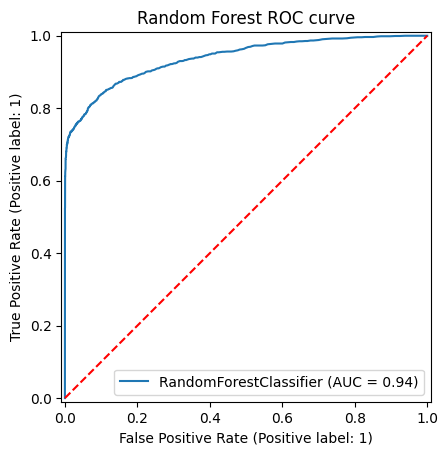

np.float64(0.9390376502243132)

In [99]:
#plot the ROC and AUC curve of the random forest

#ROC
RocCurveDisplay.from_estimator(random_forest, X=X_test_rf, y = y_test_rf)
plt.title("Random Forest ROC curve")
plt.plot([0, 1], [0, 1], "r--")
plt.show()

roc_auc_score(y_test_rf, y_prob_rf)

,Feature,Importance
8,loan_percent_income,0.209268
1,person_income,0.168215
5,loan_grade,0.127935
7,loan_int_rate,0.126476
6,loan_amnt,0.079427
2,person_home_ownership,0.068405
4,loan_intent,0.063496
3,person_emp_length,0.055709
0,person_age,0.048382
10,cb_person_cred_hist_length,0.038875


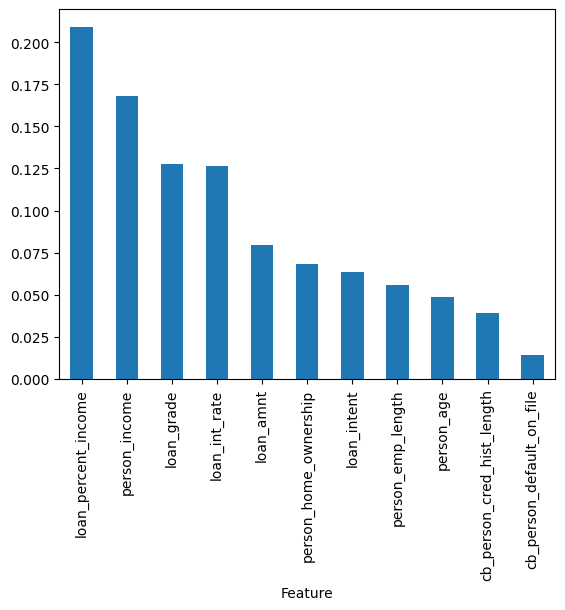

In [100]:
#Feature importance
importances = random_forest.feature_importances_
feature_names = X_test_rf.columns

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by = "Importance", ascending = False)

feature_importance_df.plot(kind = "bar", x="Feature", y= "Importance", legend = False)

display(feature_importance_df)

<h3><b>XGBoost</b></h3>

In [101]:
#ensure null values do not exist within the dataframe
credit_df.isnull().sum()

#ensure no outliers exist within the dataframe
for column in num_cols:
    print(f"{column}: {check_outliers(credit_df, column)}")

person_age: False
person_income: False
person_emp_length: False
loan_amnt: False
loan_int_rate: False
loan_percent_income: False
cb_person_cred_hist_length: False


In [102]:
#create the constants
X = credit_df.drop(["loan_status"], axis =1)
Y = credit_df["loan_status"]

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, Y, test_size = 0.2, random_state = 42)


In [103]:
from xgboost import XGBClassifier



xgbooster = XGBClassifier(objective= "binary:logistic", enable_categorical = True, seed = 42)

xgbooster = xgbooster.fit(X_train_xgb, y_train_xgb, verbose = True, eval_set = [(X_test_xgb, y_test_xgb)])

xg_training_pred = xgbooster.predict(X_train_xgb)
xg_testing_pred = xgbooster.predict(X_test_xgb)


xg_training_pred[:5]


[0]	validation_0-logloss:0.38747
[1]	validation_0-logloss:0.33061
[2]	validation_0-logloss:0.29732
[3]	validation_0-logloss:0.27468
[4]	validation_0-logloss:0.25941
[5]	validation_0-logloss:0.24816
[6]	validation_0-logloss:0.24038
[7]	validation_0-logloss:0.23555
[8]	validation_0-logloss:0.23164
[9]	validation_0-logloss:0.22841
[10]	validation_0-logloss:0.22017
[11]	validation_0-logloss:0.21678
[12]	validation_0-logloss:0.21580
[13]	validation_0-logloss:0.21062
[14]	validation_0-logloss:0.20995
[15]	validation_0-logloss:0.20837
[16]	validation_0-logloss:0.20576
[17]	validation_0-logloss:0.20431
[18]	validation_0-logloss:0.20188
[19]	validation_0-logloss:0.20056
[20]	validation_0-logloss:0.19998
[21]	validation_0-logloss:0.19902
[22]	validation_0-logloss:0.19721
[23]	validation_0-logloss:0.19686
[24]	validation_0-logloss:0.19662
[25]	validation_0-logloss:0.19579
[26]	validation_0-logloss:0.19548
[27]	validation_0-logloss:0.19491
[28]	validation_0-logloss:0.19466
[29]	validation_0-loglos

array([0, 1, 0, 0, 0])

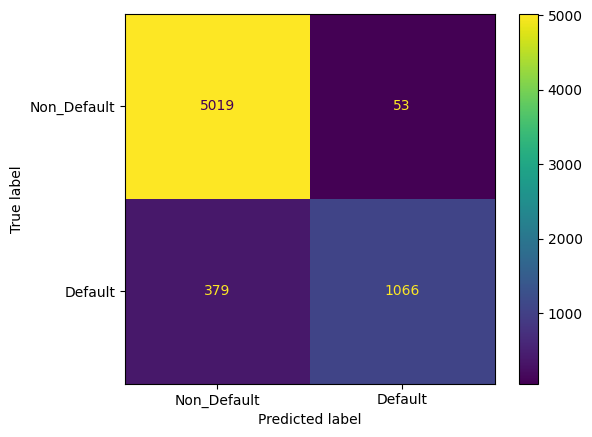

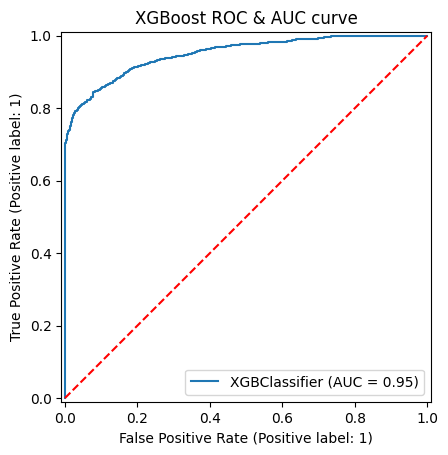

'XGBoost training set scoring:'

XGBoost training accuracy score: 0.9581414978514426
XGBoost training f1 score: 0.8939438125789831
XGBoost training ROC_AUC score: 0.9053313442313679


'XGBoost testing set scoring:'

XGBoost testing accuracy score: 0.9337118305969004
XGBoost testing f1 score: 0.8315132605304212
XGBoost testing ROC_AUC score: 0.8636333680809491


In [104]:
#plot the confusion matrix for XGBoost

xgb_confusion = confusion_matrix(y_test_xgb, xg_testing_pred)

ConfusionMatrixDisplay(confusion_matrix = xgb_confusion, display_labels = ["Non_Default", "Default"]).plot()

#plot the ROC & AUC curve

RocCurveDisplay.from_estimator(xgbooster, X_test_xgb, y_test_xgb)
plt.title("XGBoost ROC & AUC curve")
plt.plot([0,1], [0,1], "r--")
plt.show()

#Print the accuracy, f1, and ROC & AUC scores for XGBoost training sets
display(f"XGBoost training set scoring:")
print(f"XGBoost training accuracy score: {accuracy_score(y_train_xgb, xg_training_pred)}")
print(f"XGBoost training f1 score: {f1_score(y_train_xgb, xg_training_pred)}")
print(f"XGBoost training ROC_AUC score: {roc_auc_score(y_train_xgb, xg_training_pred)}")



#print the accuracy, f1, and ROC & AUC scores for XGBoost testing sets
display("XGBoost testing set scoring:")
print(f"XGBoost testing accuracy score: {accuracy_score(y_test_xgb, xg_testing_pred)}")
print(f"XGBoost testing f1 score: {f1_score(y_test_xgb, xg_testing_pred)}")
print(f"XGBoost testing ROC_AUC score: {roc_auc_score(y_test_xgb, xg_testing_pred)}")

In [105]:
#classification report for XGBoost
xgb_report = classification_report(y_test_xgb, xg_testing_pred)

print(xgb_report)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5072
           1       0.95      0.74      0.83      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.90      6517
weighted avg       0.93      0.93      0.93      6517



<h4><b>Optimizing Hyperparameters using cross-validation and GridSearch() for XGBoost</b></h4>

In [107]:
from sklearn.model_selection import GridSearchCV
param_grid_1 = {
    "max_depth" : [3, 4, 5],
    "learning_rate" : [0.1, 0.01, 0.05],
    "gamma" : [0, 0.25, 1.0],
    "reg_lambda" : [0, 1.0, 10.0],
    "scale_pos_weight" : [1, 3, 5] 
}

optimal_params = GridSearchCV(
    estimator = XGBClassifier(objective = "binary:logistic",
                              seed = 42,
                              subsample= 0.9,
                              colsample_bytree = 0.5),

                param_grid= param_grid_1,
                scoring = "roc_auc",
                verbose = 2,
                n_jobs = 10,
                cv = 10
                

)


optimal_params_fitted = optimal_params.fit(X_train_xgb,
                   y_train_xgb,
                   eval_set = [(X_test_xgb, y_test_xgb)],
                   verbose = True)

optimal_params_fitted.best_params_

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
[0]	validation_0-logloss:0.74699
[1]	validation_0-logloss:0.71364
[2]	validation_0-logloss:0.68046
[3]	validation_0-logloss:0.64922
[4]	validation_0-logloss:0.63998
[5]	validation_0-logloss:0.62081
[6]	validation_0-logloss:0.60745
[7]	validation_0-logloss:0.59238
[8]	validation_0-logloss:0.57346
[9]	validation_0-logloss:0.55918
[10]	validation_0-logloss:0.55595
[11]	validation_0-logloss:0.53887
[12]	validation_0-logloss:0.52401
[13]	validation_0-logloss:0.51093
[14]	validation_0-logloss:0.50061
[15]	validation_0-logloss:0.49263
[16]	validation_0-logloss:0.48210
[17]	validation_0-logloss:0.47413
[18]	validation_0-logloss:0.46685
[19]	validation_0-logloss:0.45878
[20]	validation_0-logloss:0.45261
[21]	validation_0-logloss:0.44262
[22]	validation_0-logloss:0.43997
[23]	validation_0-logloss:0.43438
[24]	validation_0-logloss:0.43255
[25]	validation_0-logloss:0.42720


c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[26]	validation_0-logloss:0.42349
[27]	validation_0-logloss:0.41767
[28]	validation_0-logloss:0.41496
[29]	validation_0-logloss:0.41217
[30]	validation_0-logloss:0.40539
[31]	validation_0-logloss:0.40111
[32]	validation_0-logloss:0.39901
[33]	validation_0-logloss:0.39595
[34]	validation_0-logloss:0.39382
[35]	validation_0-logloss:0.39215
[36]	validation_0-logloss:0.38801
[37]	validation_0-logloss:0.38533
[38]	validation_0-logloss:0.38026
[39]	validation_0-logloss:0.37823
[40]	validation_0-logloss:0.37777
[41]	validation_0-logloss:0.37595
[42]	validation_0-logloss:0.37494
[43]	validation_0-logloss:0.37404
[44]	validation_0-logloss:0.37128
[45]	validation_0-logloss:0.36759
[46]	validation_0-logloss:0.36648
[47]	validation_0-logloss:0.36492
[48]	validation_0-logloss:0.36337
[49]	validation_0-logloss:0.36065
[50]	validation_0-logloss:0.35867
[51]	validation_0-logloss:0.35692
[52]	validation_0-logloss:0.35640
[53]	validation_0-logloss:0.35400
[54]	validation_0-logloss:0.35326
[55]	validatio

{'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 5,
 'reg_lambda': 0,
 'scale_pos_weight': 5}

Accuracy score: 0.8787785791008133
f1: 0.7514159848961611
ROC_AUC: 0.8600139308831716


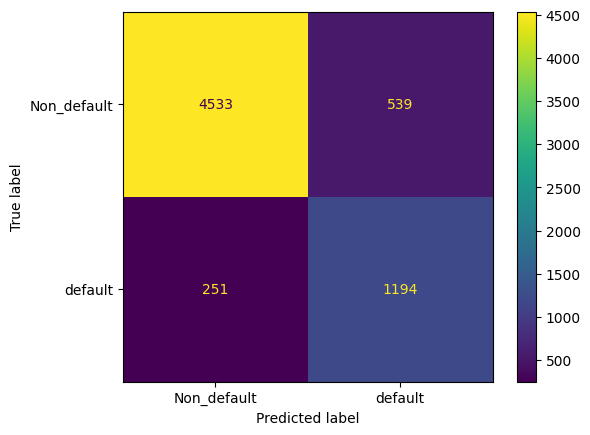

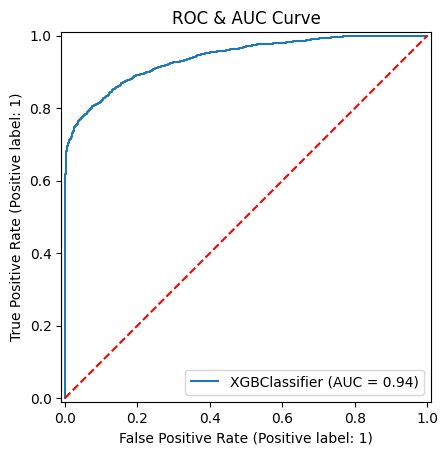

In [110]:
#optimized XGBoost Model using optimal_params_1

optimal_xgb = XGBClassifier(
    objective = "binary:logistic",
    enable_categorical = True,
    seed = 42,
    subsample = 0.9,
    colsample_bytree = 0.5,
    gamma = 0.25,
    learning_rate = 0.1,
    max_depth = 5,
    reg_lambda = 0,
    scale_pos_weight = 5
)


optimal_xgb = optimal_xgb.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = optimal_xgb.predict(X_test_xgb)

y_proba_xgb = optimal_xgb.predict_proba(X_test_xgb)[:,1]


print(f"Accuracy score: {accuracy_score(y_test_xgb, y_pred_xgb)}")
print(f"f1: {f1_score(y_test_xgb, y_pred_xgb)}")
print(f"ROC_AUC: {roc_auc_score(y_test_xgb, y_pred_xgb)}")




c_matrix = confusion_matrix(y_test_xgb, y_pred_xgb)
ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels= ["Non_default", "default"]).plot()


#plot ROC & AUC

RocCurveDisplay.from_estimator(optimal_xgb, X_test_xgb, y_test_xgb)
plt.title("ROC & AUC Curve")
plt.plot([0,1], [0,1], "r--")
plt.show()


In [111]:
param_grid_2 = {
    "max_depth" : [3, 4, 5],
    "learning_rate" : [0.1, 0.5, 1],
    "gamma" : [0.25],
    "reg_lambda" : [10.0, 20, 100],
    "scale_pos_weight" : [3] 
}

optimal_params = GridSearchCV(
    estimator = XGBClassifier(objective = "binary:logistic",
                              seed = 42,
                              subsample= 0.9,
                              colsample_bytree = 0.5),

                param_grid= param_grid_2,
                scoring = "roc_auc",
                verbose = 2,
                n_jobs = 10,
                cv = 10
                

)

optimal_params_fitted = optimal_params.fit(X_train_xgb,
                   y_train_xgb,
                   eval_set = [(X_test_xgb, y_test_xgb)],
                   verbose = True)

optimal_params_fitted.best_params_

Fitting 10 folds for each of 27 candidates, totalling 270 fits
[0]	validation_0-logloss:0.48708
[1]	validation_0-logloss:0.43306
[2]	validation_0-logloss:0.39692
[3]	validation_0-logloss:0.37800
[4]	validation_0-logloss:0.37671
[5]	validation_0-logloss:0.36741
[6]	validation_0-logloss:0.35648
[7]	validation_0-logloss:0.34096
[8]	validation_0-logloss:0.33491
[9]	validation_0-logloss:0.32798
[10]	validation_0-logloss:0.32554
[11]	validation_0-logloss:0.30943
[12]	validation_0-logloss:0.29898
[13]	validation_0-logloss:0.29767
[14]	validation_0-logloss:0.29725
[15]	validation_0-logloss:0.29524
[16]	validation_0-logloss:0.29303
[17]	validation_0-logloss:0.29211
[18]	validation_0-logloss:0.28610
[19]	validation_0-logloss:0.28435
[20]	validation_0-logloss:0.28247
[21]	validation_0-logloss:0.28037
[22]	validation_0-logloss:0.28052
[23]	validation_0-logloss:0.27906
[24]	validation_0-logloss:0.27957
[25]	validation_0-logloss:0.27953
[26]	validation_0-logloss:0.27890
[27]	validation_0-logloss:0.2

{'gamma': 0.25,
 'learning_rate': 0.5,
 'max_depth': 4,
 'reg_lambda': 20,
 'scale_pos_weight': 3}

Accuracy score: 0.9113088844560381
f1: 0.798465829846583
ROC_AUC: 0.8687884088502723


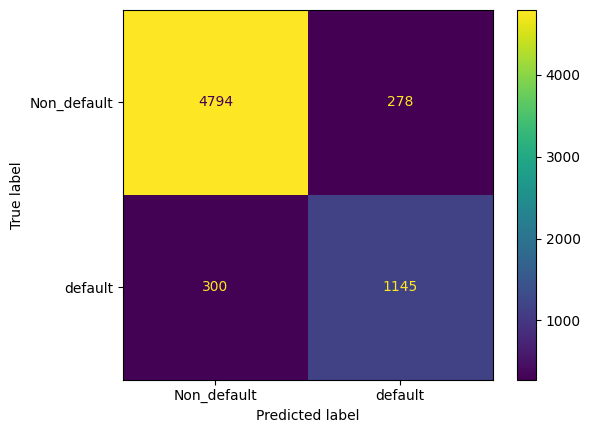

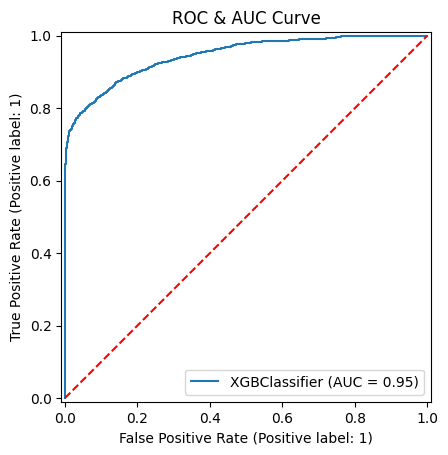

In [ ]:
#optimized XGBoost Model using optimal_params_2

optimal_xgb = XGBClassifier(
    objective = "binary:logistic",
    enable_categorical = True,
    seed = 42,
    subsample = 0.9,
    colsample_bytree = 0.5,
    gamma = 0.25,
    learning_rate = 0.5,
    max_depth = 4,
    reg_lambda = 20,
    scale_pos_weight = 3
)


optimal_xgb = optimal_xgb.fit(X_train_xgb, y_train_xgb)

y_pred_xgb = optimal_xgb.predict(X_test_xgb)

y_proba_xgb = optimal_xgb.predict_proba(X_test_xgb)[:,1]


print(f"Accuracy score: {accuracy_score(y_test_xgb, y_pred_xgb)}")
print(f"f1: {f1_score(y_test_xgb, y_pred_xgb)}")
print(f"ROC_AUC: {roc_auc_score(y_test_xgb, y_pred_xgb)}")



c_matrix = confusion_matrix(y_test_xgb, y_pred_xgb)
ConfusionMatrixDisplay(confusion_matrix = c_matrix, display_labels= ["Non_default", "default"]).plot()


#plot ROC & AUC

RocCurveDisplay.from_estimator(optimal_xgb, X_test_xgb, y_test_xgb)
plt.title("ROC & AUC Curve")
plt.plot([0,1], [0,1], "r--")
plt.show()


We will go with the 1st optimal params settings for XGBoost, since its results has less risk of overfitting than the second optimal params with a CV of 10.

,Feautres,Scores
5,loan_grade,0.320516
2,person_home_ownership,0.237484
8,loan_percent_income,0.204146
4,loan_intent,0.075408
1,person_income,0.052518
3,person_emp_length,0.029215
0,person_age,0.020181
7,loan_int_rate,0.019126
6,loan_amnt,0.015328
9,cb_person_default_on_file,0.013081


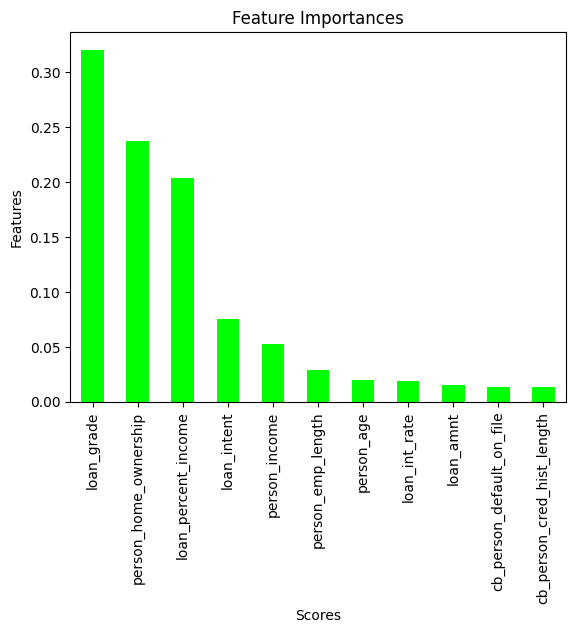

In [ ]:
#Feature Importance

feature_importance_scores = xgbooster.feature_importances_

feature_importance_df = pd.DataFrame({"Feautres":X_train_xgb.columns, "Scores": feature_importance_scores}).sort_values(by = "Scores",
                                                                                                                        ascending= False)

display(feature_importance_df)

feature_importance_df.plot(kind = "bar", x= "Feautres", y = "Scores", color = "lime", legend = False)
plt.title("Feature Importances")
plt.xlabel("Scores")
plt.ylabel("Features")
plt.show()

<h4><b>Cross Validation Comparison</b></h4>

In [112]:

rf_prediction = random_forest.predict(X_test_rf)


def model_scoring(y_test, y_predict):
    print(f"Accuracy Score: {accuracy_score(y_test, y_predict)}")
    print(f"F1 Score: {f1_score(y_test, y_predict)}")
    print(f"ROC_AUC Score: {roc_auc_score(y_test, y_predict)}")

display("Prediction Results for Random Forests")
model_scoring(y_test_rf, y_pred_rf)



'Prediction Results for Random Forests'

Accuracy Score: 0.9289550406628817
F1 Score: 0.8142799839550742
ROC_AUC Score: 0.8479579180902274


<h4><b>Random Forests Cross Validation</b></h4>

In [118]:
from sklearn.model_selection import RandomizedSearchCV

rf_param_dist = {
    "n_estimators": [100, 200],
    "max_depth" : [3, 4, 5],
    "min_samples_split" : [2, 5, 10],
    "min_samples_leaf" : [1, 2, 4],
    "max_features" : ["sqrt", "log2"],
    "bootstrap" : [True]
}


rf_random_search = RandomizedSearchCV(estimator = random_forest, param_distributions = rf_param_dist, scoring = "roc_auc",
                                           n_iter = 50, cv = 10, n_jobs = -1, error_score = "raise").fit(X_train_rf, y_train_rf,
                                                                                     )

print(f"Best parameters: {rf_random_search.best_params_}")
print(f"Best ROC_AUC: {rf_random_search.best_score_:2f}")

Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': True}
Best ROC_AUC: 0.901507


In [119]:
rf_best_params = {'n_estimators': 200, 
                  'min_samples_split': 10, 
                  'min_samples_leaf': 1, 
                  'max_features': 'log2',
                    'max_depth': 5,
                      'bootstrap': True}

optimized_rf_clf = RandomForestClassifier(n_estimators = 500,
                                           min_samples_split = 5,
                                             min_samples_leaf = 1,
                                             max_features= "log2",
                                             max_depth=None,
                                             bootstrap=True).fit(X_train_rf, y_train_rf)


optimized_rf_pred = optimized_rf_clf.predict(X_test_rf)

optimized_rf_proba = optimized_rf_clf.predict_proba(X_test_rf)[:,1]

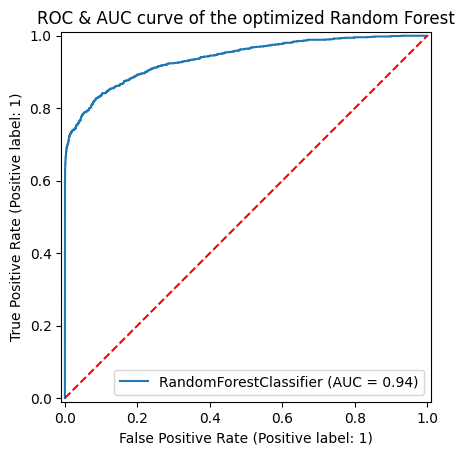

Accuracy Score: 0.9280343716433942
F1 Score: 0.8118732450862415
ROC_AUC Score: 0.8466241144815693


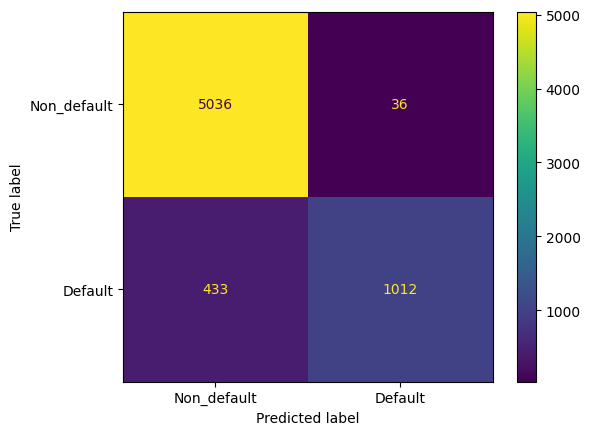

In [120]:
RocCurveDisplay.from_estimator(optimized_rf_clf, X_test_rf, y_test_rf)
plt.title("ROC & AUC curve of the optimized Random Forest")
plt.plot([0,1], [0,1], "r--")
plt.show()

optimized_rf_cm = confusion_matrix(y_pred=optimized_rf_pred, y_true=y_test_rf)
ConfusionMatrixDisplay(confusion_matrix=optimized_rf_cm, display_labels= ["Non_default", "Default"]).plot()

model_scoring(y_test = y_test_rf, y_predict = optimized_rf_pred)


### **Model Performance Evaluation and Interpretation**

We evaluated three models—Logistic Regression, Random Forest, and XGBoost—using cross-validation to assess their ability to predict credit risk. Below is the analysis and interpretation of their performance across three metrics: **Accuracy**, **F1 Score**, and **ROC_AUC**.

#### **Logistic Regression**
- **Accuracy Score:** 0.81
- **F1 Score:** 0.64  
- **ROC_AUC Score:** 0.8

**Interpretation:**  
Logistic Regression achieved moderate accuracy and ROC_AUC scores. However, its F1 score is relatively low, indicating difficulties in handling imbalanced data or predicting positive class outcomes. While Logistic Regression is interpretable and straightforward, it lacks the complexity to capture nuanced relationships in the dataset, making it less suitable for this use case.

---

#### **Random Forest**
- **Accuracy Score:** 0.93  
- **F1 Score:** 0.81  
- **ROC_AUC Score:** 0.85  

**Interpretation:**  
Random Forest performed exceptionally well across all metrics. Its high F1 score reflects a strong balance between precision and recall, meaning it handles both false positives and false negatives effectively. Additionally, its competitive accuracy and ROC_AUC scores highlight its reliability in classification tasks and ranking predictions. Random Forest's robustness makes it the most consistent model for this dataset.

---

#### **XGBoost**
- **Accuracy Score:** 0.88 
- **F1 Score:** 0.75
- **ROC_AUC Score:** 0.86  

**Interpretation:**  
XGBoost demonstrated strong results, achieving the highest ROC_AUC score, which indicates superior ability to rank predictions correctly. Its accuracy and F1 score are slightly lower than those of Random Forest, but it remains highly competitive. XGBoost's advanced boosting mechanism makes it effective in handling complex patterns and imbalanced data, although it might require more fine-tuning.

---

### **Conclusion and Model Selection**

- **Best Model:** **Random Forest**  
  - It is the most consistent performer, excelling in accuracy and F1 score, making it suitable for scenarios where balanced performance is critical across both classes.
  
- **Alternative Model:** **XGBoost**  
  - It is the best model for situations where ranking predictions (e.g., ROC_AUC) is the primary objective, such as prioritizing high-risk loans for further scrutiny.

- **Logistic Regression** was outperformed by the other two models and is not recommended for this dataset due to its limited capacity to model complex relationships and handle class imbalance effectively.


<h4><b>Model Selection</b></h4>

<p>When comparing the 10 folded cross validation results between all models with the use of the testing datasets, our winner would be the <b>Random Forest Model</b>. Therefore, we will use it for our credit risk modeling.</p> 

In [175]:
#Calculating loss given default

#randomize the constant LGD for expected loss calculation
LGD = np.random.uniform(0.20, 0.60)

rf_prob_df = pd.DataFrame({"rf_probs_def": y_prob_rf,
                           "rf_status_pred": y_pred_rf,
                           "actual_status": y_test_rf,
                           "loan_amnt" : X_test_rf["loan_amnt"]})

#calculate the expected loss of the portfolio using the formula : PD * LGD * loan_amnt

rf_prob_df["expected_loss"] = rf_prob_df["rf_probs_def"] * LGD * rf_prob_df["loan_amnt"]





In [ ]:
#calculate the interest income of the random forest portfolio

rf_prob_df["loan_int_rate"] = X_test_rf["loan_int_rate"] / 100

rf_prob_df["interest_income"] = (rf_prob_df["loan_amnt"] * rf_prob_df["loan_int_rate"]) 
#calculate the risk adjusted return (RAROC) for each profile
rf_prob_df["RAROC"] = rf_prob_df.apply(
    lambda row: row["interest_income"] / row["expected_loss"] if row["expected_loss"] != 0 else row["interest_income"], 
    axis=1
)

display(rf_prob_df.head(50))
#ensure that there are no missing values within the dataframe
display(rf_prob_df.isnull().sum())

,rf_probs_def,rf_status_pred,actual_status,loan_amnt,expected_loss,loan_int_rate,interest_income,RAROC
14668,0.026,0,0,10000,73.863223,0.1037,1037.000,14.039463
24614,0.189,0,0,10000,536.928812,0.1527,1527.000,2.843952
11096,0.282,0,0,16000,1281.811005,0.1099,1758.400,1.371809
10424,0.977,1,1,10000,2775.552642,0.1099,1099.000,0.395957
26007,0.973,1,1,13000,3593.445790,0.1632,2121.600,0.590408
9614,0.117,0,0,20000,664.769005,0.0999,1998.000,3.005555
6204,0.034,0,0,6000,57.954221,0.0999,599.400,10.342646
19286,0.008,0,0,2500,5.681786,0.0579,144.750,25.476143
10297,0.050,0,0,9600,136.362873,0.1385,1329.600,9.750455
20560,0.035,0,0,3000,29.829378,0.0714,214.200,7.180840


rf_probs_def       0
rf_status_pred     0
actual_status      0
loan_amnt          0
expected_loss      0
loan_int_rate      0
interest_income    0
RAROC              0
dtype: int64

<h3><b>Segmenting Profiles with K-means</b></h3>

In [209]:
from sklearn.cluster import KMeans

#select the features for clustering profiles
features = rf_prob_df[["rf_probs_def", "expected_loss", "RAROC", "interest_income"]]

features_scaled = scaler.fit_transform(features)

#apply kmeans
kmeans = KMeans(n_clusters=3, random_state = 42).fit(features_scaled)
rf_prob_df["risk_cluster"] = kmeans.labels_



<h4><b>Evaluating our KMeans Model</b></h4>

Before Diving into the cluster analysis, let us evaluate the quality of our clusters and check how well each data point fits within its cluster compared to the other clusters. This will provide insights into the cohesiveness and seperation of our clusters.

In [218]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(features_scaled, rf_prob_df["risk_cluster"])



if sil_score > 0.5:
    result = print(f"Silhouette score: {sil_score:.2f}. Good Clustering Structure.")
elif 0.5 > sil_score > 0.2:
    result = print(f"Silhouette score: {sil_score:.2f}. Clusters are reasonable but may overlap.")
else:
    result = print(f"Sihouette score: {sil_score:.2f}. Clusters are poorly defined.")



Silhouette score: 0.47. Clusters are reasonable but may overlap.


Based on the silhouette score above, 0.47 is still considered to be very close to 0.5, which is why we will be keeping k = 3.

<h4><b>Cluster Analysis</b></h4>

<b>Here is our Risk Benchmark:</b>

* <b>Probability of Default (PD):</b>

     * High PD → Higher likelihood of default → Higher risk.
* <b>Expected Loss (EL):</b>

     * High EL → Greater potential loss if the borrower defaults → Higher risk.

* <b>RAROC:</b>
     * Low RAROC → Less profitability relative to risk → Higher risk.

* <b>Interest Income:</b>

    * Helps evaluate return potential for each cluster.


<b>Risk Levels:</b>

* High Risk: Cluster with High PD & EL, and lower RAROC.
* Moderate Risk: Cluster with all values being Moderate. 
* Low Risk: Cluster with all low PD & EL, and Higher RAROC. 

<hr>

In [242]:
#let us analyze the clusters
cluster_summary = rf_prob_df.groupby("risk_cluster").agg({
    "rf_probs_def" : "mean",
    "expected_loss" : "mean",
    "RAROC" : "mean",
    "interest_income" : "mean",
    "loan_amnt": "mean"
}).round(2)

cluster_summary = cluster_summary.rename(columns = {"rf_probs_def": "PD", "expected_loss" : "EL"})

print(cluster_summary)

                PD       EL  RAROC  interest_income  loan_amnt
risk_cluster                                                  
0             0.09   148.05  30.24           683.83    6974.06
1             0.92  3076.82   0.53          1611.76   11892.00
2             0.12   607.98  10.42          2259.49   18195.71


<h4><b>Interpreting the Results</b></h4>

<b>Cluster 0:</b> 

* PD (0.09): Very low probability of default.
* Expected Loss (148.05): Minimal potential loss.
* RAROC (30.24): Exceptionally high, indicating very favorable risk-adjusted returns.
* Interest Income (683.83): Relatively low income, due to smaller loan amounts.
* Loan Amount (6974.06): Lowest among the clusters

<b>Interpretation:</b>

This cluster represents low-risk borrowers who are very unlikely to default and offer high risk-adjusted returns, albeit with smaller loans and lower income potential.

<b>Cluster 1:</b>

* PD (0.92): Extremely high probability of default.
* Expected Loss (3076.82): Very high potential loss.
* RAROC (0.53): Negligible risk-adjusted return, indicating these loans are not profitable relative to their risk.
* Interest Income (1611.76): Moderate income potential, despite high risk.
* Loan Amount (11892.00): Moderate loan sizes.


<b>Interpretation:</b>

This cluster represents high-risk borrowers with a high likelihood of default, significant expected losses, and poor profitability. These loans are the riskiest and least favorable for the portfolio.

<b>Cluster 2:</b>

* PD (0.12): Low probability of default.
* Expected Loss (607.98): Moderate potential loss.
* RAROC (10.42): Decent risk-adjusted returns, though not as high as Cluster 0.
* Interest Income (2259.49): Highest income potential among the clusters.
* Loan Amount (18195.71): Largest loan sizes.

<b>Interpretation:</b>

This cluster represents medium-risk borrowers who are relatively safe but carry moderate losses and offer good profitability. They represent a balanced risk-reward segment.


If we were to focus on increasing substantial profits for the bank, taking action against Cluster 2 would be the most beneficial due to their high loan and high interest income profiles. However, this is about managing risk so our target would be Cluster 1.

<hr>
<hr>

T<b>herefore we will classify the following Clusters as:</b>

* <b>Cluster 0: Low Risk</b>
* <b>Cluster 2: Moderate Risk</b>
* <b>Cluster 1; High Risk</b>

<h3><b>Visualizing Our clusters</b></h3>

Before we move on to the visualization of our model, we need to first map the cluster levels with respect to their risk levels, as well as their colors.

In [219]:
#map the clusters

rf_prob_df["risk_cluster_label"] = rf_prob_df["risk_cluster"].map({
    0 : "Low Risk",
    1: "High Risk",
    2: "Moderate Risk"
})

rf_prob_df.head()

,rf_probs_def,rf_status_pred,actual_status,loan_amnt,expected_loss,loan_int_rate,interest_income,RAROC,risk_cluster,risk_cluster_label
14668,0.026,0,0,10000,73.863223,0.1037,1037.0,14.039463,0,Low Risk
24614,0.189,0,0,10000,536.928812,0.1527,1527.0,2.843952,2,Moderate Risk
11096,0.282,0,0,16000,1281.811005,0.1099,1758.4,1.371809,2,Moderate Risk
10424,0.977,1,1,10000,2775.552642,0.1099,1099.0,0.395957,1,High Risk
26007,0.973,1,1,13000,3593.445790,0.1632,2121.6,0.590408,1,High Risk


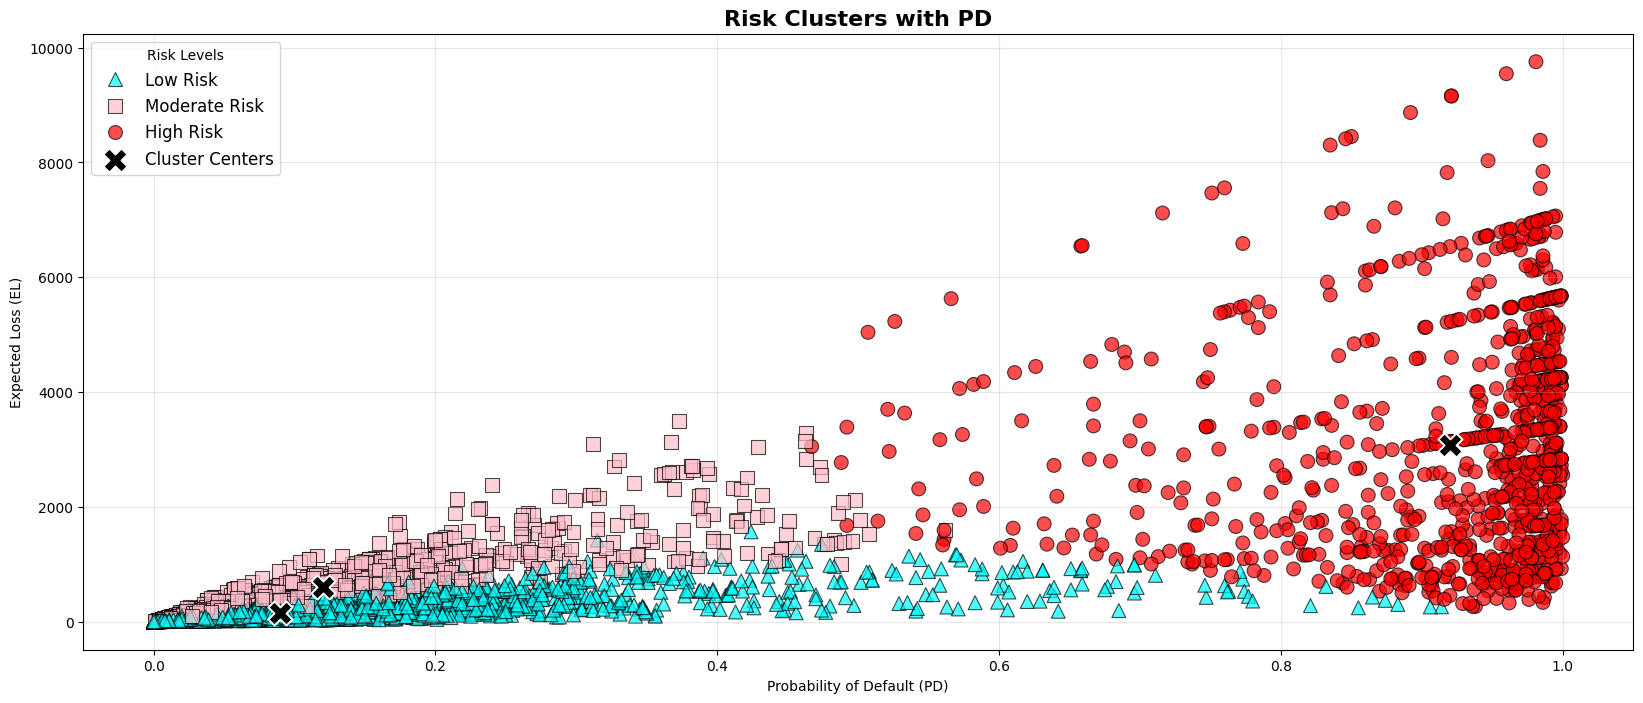

In [280]:
#lets visualize the clusters
plt.figure(figsize=(20,8))
sns.scatterplot(
    data = rf_prob_df,
    x = "rf_probs_def",
    y = "expected_loss",
    hue="risk_cluster_label",
    palette={"High Risk": "red", "Moderate Risk": "pink", "Low Risk": "aqua"},
    style = "risk_cluster_label",
    markers = {"High Risk": "o", "Moderate Risk": "s", "Low Risk": "^"},
    s = 100, #market size
    edgecolor= "k", #add edgecolors to markets
    alpha=0.7 #transparency for readability
    
    
    )


sns.scatterplot(
    x=cluster_summary["PD"],
    y=cluster_summary["EL"],
    color = "black",
    marker = "X",
    s=300,
    label="Cluster Centers"
)

plt.xlabel("Probability of Default (PD)")
# plt.xlim([0,1.01])
plt.ylabel("Expected Loss (EL)")
plt.title("Risk Clusters with PD", fontsize = 16, fontweight = "bold")
plt.legend(title = "Risk Levels", fontsize = 12)
plt.grid(alpha=0.3)


plt.show()

### **Financial Impact Analysis:**

In this section, we evaluate the financial impact of the loan portfolio by calculating key metrics for each risk cluster identified using K-Means clustering. The goal is to assess how each cluster contributes to the overall **Expected Loss** and **Risk-Adjusted Return on Capital (RAROC)**, and to understand the proportion of **Interest Income** that each cluster contributes to the portfolio.

### 1. Expected Portfolio Loss

The **Expected Loss (EL)** is the product of the **Probability of Default (PD)**, the **Loss Given Default (LGD)**, and the **Exposure at Default (EAD)** for each loan. The total expected loss for the portfolio will be calculated by summing the expected losses for each loan within the clusters.

#### Formula for Expected Loss:

$$
\text{Expected Loss} = \text{PD} \times \text{LGD} \times \text{EAD}
$$


- We will group the loans by their **cluster label** and calculate the total expected loss for each cluster.
- This will provide us with insights into the risk exposure across the portfolio.

In [304]:
#check which cluster has the highest amount of defaults

high_risk = rf_prob_df[rf_prob_df["risk_cluster_label"] == "High Risk"]

moderate_risk = rf_prob_df[rf_prob_df["risk_cluster_label"] == "Moderate Risk"]

low_risk = rf_prob_df[rf_prob_df["risk_cluster_label"] == "Low Risk"]

print(high_risk["rf_status_pred"].value_counts())

print(moderate_risk["rf_status_pred"].value_counts())

print(low_risk["rf_status_pred"].value_counts())

rf_status_pred
1    965
0      4
Name: count, dtype: int64
rf_status_pred
0    1064
1       3
Name: count, dtype: int64
rf_status_pred
0    4401
1      80
Name: count, dtype: int64


According to the results above, the high risk cluster label has the highest amount of defaults compared to the other labels, which makes sense given how risky its metrics are.

In [312]:
#group by lthe Clusters and calculate the total Expected Loss for each Cluster

cluster_loss = rf_prob_df.groupby("risk_cluster_label")["expected_loss"].sum()

print(cluster_loss)

def_exp_loss = 0

for index, row in high_risk.iterrows():
    if row["rf_status_pred"] == 1:
        def_exp_loss += row["expected_loss"]

print("-"*80)

print(f"Total Expected Loss from the High Risk Cluster predicted by Random Forests: ${def_exp_loss:.2f}")


risk_cluster_label
High Risk        2.981436e+06
Low Risk         6.634196e+05
Moderate Risk    6.487137e+05
Name: expected_loss, dtype: float64
--------------------------------------------------------------------------------
Total Expected Loss from the High Risk Cluster predicted by Random Forests: $2970544.89


If our target were only the High Risk customers that **random forests** predicted are going to default, The total expected Loss is **2,970,544 USD** compared to the rest of the expected loss for this cluster which is **2,981,436 USD**. The expected loss for consumers whom which random forests predicted that are not going to default is **(2,981,436 - 2,970,544) 10,892 USD**. Let us compare these results with the actual individuals who have defaulted within this Cluster. 

In [317]:
#set up the actual loss from defaults variable
def_actual_loss = 0

for index, row in rf_prob_df.iterrows():
    if row["actual_status"] == 1:
        def_actual_loss += row["expected_loss"]

print(f"Total Expected Loss from the High Risk Cluster predicted by Random Forests: ${def_actual_loss:.2f}")

#get the difference between results
print("-"*80)

print(f"Difference between the actual loss and the expected loss predicted by Random Forests from the High Risk Cluster: ${def_actual_loss - def_exp_loss:.2f} ")

print("-"*80)
print(f"Prediction of Error from the High Clusters using Random Forests: {(def_actual_loss - def_exp_loss)/def_actual_loss:.2f}")

Total Expected Loss from the High Risk Cluster predicted by Random Forests: $3180346.60
--------------------------------------------------------------------------------
Difference between the actual loss and the expected loss predicted by Random Forests from the High Risk Cluster: $209801.72 
--------------------------------------------------------------------------------
Prediction of Error from the High Clusters using Random Forests: 0.07


## Final Findings

When comparing the actual loss from borrower defaults with the expected loss from the Random Forests predictions, the difference or error made by the Random Forests model is **209,801 USD**, which is **7%** of the total loss. If we were to use other classification models, such as **Logistic Regression** or **XGBoost**, the percentage error might vary. However, based on the results, **Random Forests** demonstrated strong predictive performance in identifying defaulting borrowers.

---

## Conclusion

We employed classification models, including **Logistic Regression**, **Random Forests**, and **XGBoost**, to predict borrower defaults. Among these models, **Random Forests** proved the most reliable based on its evaluation metrics and model scoring.

Using the Random Forests model:  
- We leveraged its `y_predict_proba` as our **Probability of Default (PD)**.  
- We used a randomized uniform constant for **Loss Given Default (LGD)** due to the absence of recovery rate data.  
- We considered the loan amount as the **Exposure at Default (EAD)**, again constrained by the absence of recovery rate information.  

To further understand risk, we applied **K-Means clustering** to profile borrowers into risk segments. The clustering yielded a **silhouette score of 0.47**, indicating moderate cluster separation.

---

## Recommendation

While the current results are robust, incorporating actual recovery rate data could significantly improve the model's performance and reliability. Future work could focus on:  
- Integrating real recovery rate data or estimating **LGD** using external benchmarks or industry standards.  
- Exploring alternative clustering techniques or additional features to improve segmentation accuracy.  
- Applying advanced ensemble methods or deep learning approaches for further performance enhancements.

---

